In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             mean_squared_error, r2_score)
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings("ignore")

In [ ]:
DATA_PATH = "/content/drive/MyDrive/data science/cleaned_data.csv"
TARGET_COL = "Price_in_India"
RANDOM_STATE = 42
TEST_SIZE = 0.2

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data science/cleaned_data.csv')
print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())

Data shape: (8789, 10)
Columns: ['Unnamed: 0', 'Brand', 'Release_year', 'Screen-size', 'operationg_system', 'Internal_storage(GB)', 'Battery(mah)', 'RAM', 'Processor', 'Price_in_India']


In [ ]:
y_raw = df[TARGET_COL]
# If the target is numeric and has many unique values -> regression likely.
is_numeric_target = pd.api.types.is_numeric_dtype(y_raw)
unique_vals = y_raw.nunique()
print(f"Target '{TARGET_COL}' dtype: {y_raw.dtype}, unique values: {unique_vals}")

# Heuristic: treat as classification if target is non-numeric or has <= 20 unique values
if (not is_numeric_target) or (unique_vals <= 20):
    problem_type = "classification"
else:
    problem_type = "regression"
print("Problem type inferred as:", problem_type)

Target 'Price_in_India' dtype: float64, unique values: 1607
Problem type inferred as: regression


In [ ]:

# 3) Simple preprocessing
# - Drop rows where target is missing
df = df[df[TARGET_COL].notna()].copy()

# - Separate features and target
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].copy()

# - Fill missing values simply:
#   numeric: median, categorical: "missing"
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

for c in num_cols:
    med = X[c].median()
    X[c].fillna(med, inplace=True)
for c in cat_cols:
    X[c].fillna("missing", inplace=True)

# - Encode categoricals with get_dummies (simple and effective)
if len(cat_cols) > 0:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# - If classification and target is string, encode it
label_encoder = None
if problem_type == "classification" and not pd.api.types.is_numeric_dtype(y):
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    print("Label encoder classes:", label_encoder.classes_)

print("Final features shape:", X.shape)


Final features shape: (6800, 145)


In [ ]:
# 4) Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=(y if problem_type=="classification" else None)
)

In [ ]:
# 5) Choose model (CART)
if problem_type == "classification":
    model = DecisionTreeClassifier(random_state=RANDOM_STATE)
else:
    model = DecisionTreeRegressor(random_state=RANDOM_STATE)

In [ ]:
# 6) Quick baseline train
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [ ]:
# 7) Evaluation
if problem_type == "classification":
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification report:\n", classification_report(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
else:
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"RMSE: {rmse:.4f}, R2: {r2:.4f}")

RMSE: 7179.6781, R2: 0.8648


In [ ]:
# 8) Feature importances (useful)
feat_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 20 feature importances:\n", feat_importances.head(20))


Top 20 feature importances:
 Internal_storage(GB)     0.593272
Unnamed: 0               0.105996
operationg_system_iOS    0.097235
Screen-size              0.053200
RAM                      0.035002
Battery(mah)             0.034643
Brand_Apple              0.013102
Release_year             0.011908
Brand_Samsung            0.010082
Brand_Huawei             0.008040
Brand_Sony               0.004807
Brand_BlackBerry         0.003849
Brand_Asus               0.003799
Brand_Vertu              0.002429
Brand_HTC                0.002246
Brand_Motorola           0.001902
Brand_OnePlus            0.001891
Brand_Google             0.001780
Brand_Poco               0.001273
Processor_missing        0.001120
dtype: float64


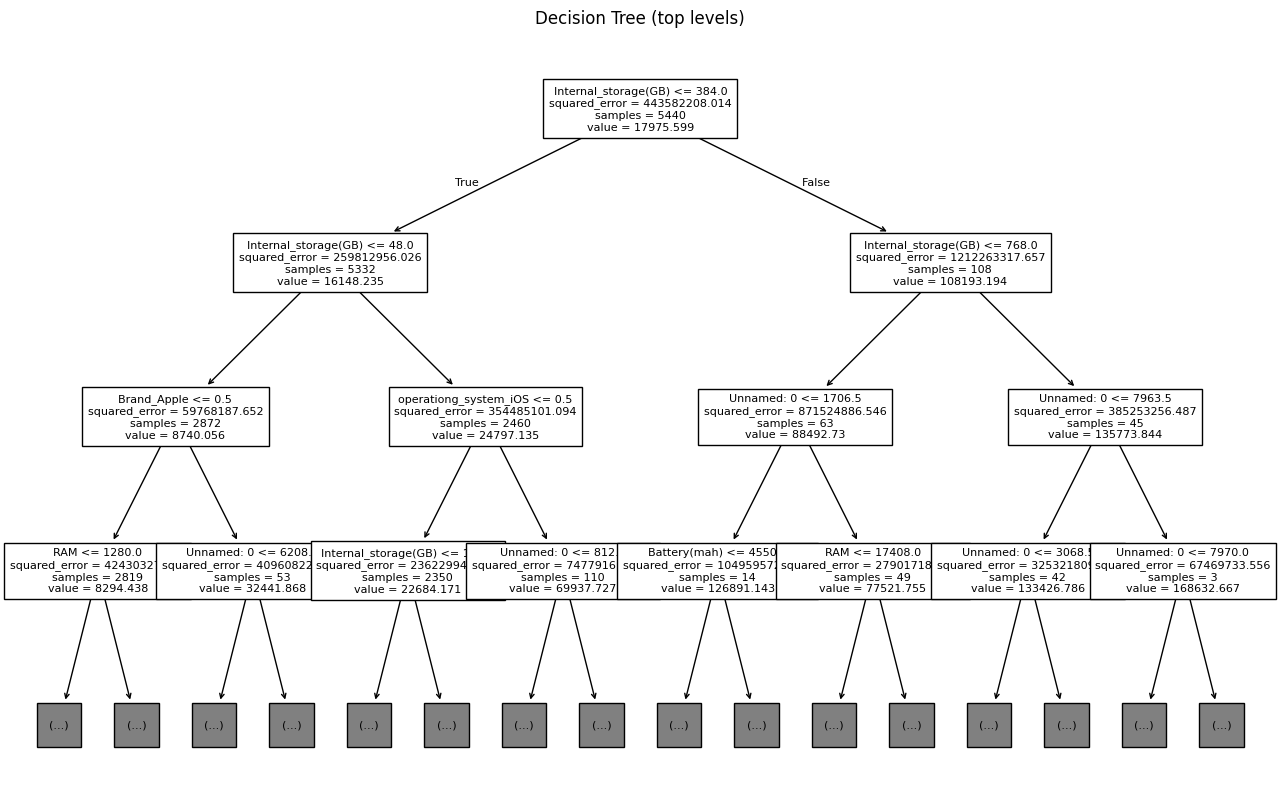

In [ ]:
# 9) Visualize the tree (small trees only - use max_depth for large trees)
plt.figure(figsize=(16,10))
plot_tree(model, feature_names=X.columns, filled=False, max_depth=3, fontsize=8)
plt.title("Decision Tree (top levels)")
plt.show()

In [ ]:
# 10) Optional: tune hyperparameters with GridSearchCV
param_grid = {
    "max_depth": [None, 3, 5, 7, 10],
    "min_samples_leaf": [1, 2, 5, 10],
    "min_samples_split": [2, 5, 10]
}
gs = GridSearchCV(model, param_grid, cv=5, scoring=("accuracy" if problem_type=="classification" else "r2"), n_jobs=-1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
best_model = gs.best_estimator_

# evaluate best model on test
y_pred_best = best_model.predict(X_test)
if problem_type == "classification":
    print("Best model accuracy:", accuracy_score(y_test, y_pred_best))
else:
    print("Best model RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
    print("Best model R2:", r2_score(y_test, y_pred_best))


Best params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best model RMSE: 7365.568875238424
Best model R2: 0.8576707770462895


In [ ]:
# 11) Save best model
joblib.dump(best_model, "best_decision_tree.pkl")
print("Saved best model to best_decision_tree.pkl")

Saved best model to best_decision_tree.pkl


In [ ]:
# 12) If label_encoder exists, save that mapping too
if label_encoder is not None:
    joblib.dump(label_encoder, "label_encoder.pkl")
    print("Saved label encoder to label_encoder.pkl")